In [3]:
import pickle
import time
import logging

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings('ignore')

class IllnessPredictionModelWorkflow():
    """
    Class instance to orchestrate model workflow
    """
    def __init__(self, train_data_path=None, test_data_path=None):
        """
        This method used to initialize the class instance attributes
        :param train_data_path: train data CSV path
        :param test_data_path: test data CSV path
        """
        self.workflow_steps = ["Load the train and test",
                               "Preprocess the train and test",
                               "Build a predictive model with the train",
                               "Predict the outcome on the validation and test",
                               "Exit"]
        self.workflow_dict = {self.workflow_steps[0]: "Not Started",
                              self.workflow_steps[1]: "Not Started",
                              self.workflow_steps[2]: "Not Started",
                              self.workflow_steps[3]: "Not Started",
                              self.workflow_steps[4]: "Not Started"}
        self.model_names = ['Decision Tree',
                            'Random Forest',
                            'Grandient Boosting Regression']
        self.model_dict = {self.model_names[0]: DecisionTreeClassifier(),
                           self.model_names[1]: RandomForestClassifier(),
                           self.model_names[2]: GradientBoostingRegressor()}

        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        self.train_dataset = None
        self.test_dataset = None
        self.selected_features = None
        self.prediction_column = ["Illness"]
        self.selected_model = None
        self.test_data_output_csv = "/Users/preethi/Downloads/CaseStudy/src/test_data_y_pred.csv"


    def load_data(self):
        """
        This method used to load train and test data
        :return: None
        """
        try:
            self.train_dataset = pd.read_csv(self.train_data_path)
            self.test_dataset = pd.read_csv(self.test_data_path)
        except FileNotFoundError as ex:
            logging.error(ex)
            raise ex

        print('The data set is loaded')

    def preprocess_data(self, input_df):
        """
        This method used to pre-process the data
        :param input_df: input data frame to pre-process the data
        :return: processed data set
        """
        dict_illness = {'No': 0, 'Yes': 1}
        dict_sex = {'Male': 0, 'Female': 1}
        simple_imputer = SimpleImputer(strategy='mean')

        # Id_Number,City,Gender,Age,Weight,Illness
        data_columns = list(input_df.columns)
        processed_dataset = input_df[data_columns].dropna()

        simple_imputer.fit(processed_dataset[['Age']])
        processed_dataset[['Age']] = simple_imputer.transform(processed_dataset[['Age']])

        if "Illness" in data_columns:
            processed_dataset['Illness'] = processed_dataset[self.prediction_column].replace(dict_illness)

        processed_dataset['Gender'] = processed_dataset['Gender'].replace(dict_sex)
        label_encoder = LabelEncoder()
        processed_dataset['City'] = label_encoder.fit(processed_dataset["City"])\
                                    .transform(processed_dataset["City"])

        return processed_dataset


    def build_model(self, x_train_data=None, y_train_data=None):
        """
        BUILD REGRESSION MODEL WITH 0.68 and it will be > 91%
        This method will receive X , Y training data set and build a model based on user choice
        :param x_train_data: X axis training data set
        :param y_train_data: Y axis training data set
        :return: None
        """
        for i, name in enumerate(self.model_names):
            print(f' {i+1}) {name}')

        print('Please choose the model: ')

        model_index = int(input()) - 1

        clf = self.model_dict[self.model_names[model_index]].fit(x_train_data, y_train_data)

        print(f'{self.model_names[model_index]} model is built')

        print('Do you want to save the model? (y/n)')

        model_save_flag = str(input().strip())

        if model_save_flag.upper() == 'Y':
            t_stamp = time.strftime("%Y%m%d-%H%M%S")
            model_file = f"{t_stamp}.{self.model_names[model_index].replace(' ', '.')}.pickle"
            with open(model_file, 'wb') as model_file_ref:
                pickle.dump(clf, model_file_ref)

            print(f'The model is built and saved as {model_file}...')

        self.selected_model = clf

    def execute_model_prediction(self, x_validation, y_validation):
        """
        This method will execute the model predictions and save the predictions
        :param x_validation: X axis validation set
        :param y_validation: Y axis validation set
        :return: None
        """
        accuracy = self.selected_model.score(x_validation, y_validation)

        print(f'The accuracy of the model is {accuracy:.5f}')

        #print("Do you want to see the confusion matrix? (y/n)")

        confuse_mtx_flag = 'Y' #str(input().strip())

        y_pred = self.selected_model.predict(x_validation)

        if confuse_mtx_flag.upper() == 'Y':
            print(confusion_matrix(y_validation, y_pred))

        #print("Do you want to save the outcome for the test data ? (y/n)")

        outcome_flag = 'Y' #str(input().strip())

        if outcome_flag.upper() == 'Y':
            y_pred = self.selected_model.predict(self.test_dataset[self.selected_features])
            final_df = pd.DataFrame(y_pred,columns=["Illness"])
            #final_result_df = self.test_dataset.append(final_df["Illness"])
            list_of_values = final_df["Illness"].tolist()
            self.test_dataset["Illness"] = list_of_values
            self.test_dataset.to_csv(self.test_data_output_csv)
            #input_df = pd.read_csv(self.test_data_output_csv)
            #pd.value_counts(input_df['Illness']).plot.barh()

    def split_train_dataset(self):
        """
        This method will split the input training data set and select the user features
        :return: X axis training data set , Y axis training data set,
         X axis validation data set  and Y axis validation data set
        """
        feature_list = list(self.train_dataset.columns)

        print('Select the features to consider (ex. 13 -> City, Age)')

        for index in range(len(feature_list)-1):
            print(f' {index+1}) { feature_list[index]}')

        feature_index = int(input())

        self.selected_features = [feature_list[int(feature_index)-1] for feature_index in str(feature_index)]

        print(f'Features selected: {self.selected_features}')

        print('Enter the train:validation split ratio (ex. 7:3)')
        ratio_input = str(input().strip())
        train_size = int(ratio_input[0]) * 0.01

        x_train, x_validation, y_train, y_validation = \
            train_test_split(self.train_dataset[self.selected_features],
                             self.train_dataset[self.prediction_column], train_size=train_size)

        print(f'The train data is split into train and validation set with {ratio_input} ratio')

        return x_train, x_validation, y_train, y_validation

    def execute_workflow(self):
        """
        This method will orchestrate the model execution flow
        :return:
        """
        x_train, x_validation, y_train, y_validation = None, None, None, None

        while True:

            try:
                self.display_workflow_status()

                flow_index = int(input().strip()) - 1

                if flow_index > 0  and  \
                                self.workflow_dict[self.workflow_steps[flow_index - 1]] != "COMPLETED":
                    print(f"Incorrect value, please choose value less than {flow_index}, "
                          f"Step {self.workflow_steps[flow_index - 1]} "
                          f"has to complete to proceed further")
                    continue

                if flow_index == 0:
                    self.load_data()
                elif flow_index == 1:
                    self.train_dataset = self.preprocess_data(self.train_dataset)
                    self.test_dataset = self.preprocess_data(self.test_dataset)
                    x_train, x_validation, y_train, y_validation = self.split_train_dataset()

                elif flow_index == 2:
                    self.build_model(x_train_data=x_train, y_train_data=y_train)
                    pass
                elif flow_index == 3:
                    self.execute_model_prediction(x_validation=x_validation, y_validation=y_validation)
                else:
                   return

                self.workflow_dict[self.workflow_steps[flow_index]] = "COMPLETED"
            except Exception as ex:
                logging.error(ex)
    def display_workflow_status(self):
        """
        This method will display workflow steps
        :return: None
        """

        for i, name in enumerate(self.workflow_dict):
            print(f' {i+1}) {name} - { self.workflow_dict[name]}')

        print('Please choose the workflow step: ')

def main():
    """
    This method will act as a trigger for the entire workflow
    :return: None
    """
    train_data_path = '/Users/preethi/Downloads/CaseStudy/src/train_data.csv'
    test_data_path = '/Users/preethi/Downloads/CaseStudy/src/test_data_X.csv'

    illness_workflow = IllnessPredictionModelWorkflow(train_data_path=train_data_path,
                                                      test_data_path=test_data_path)

    print("Welcome! ")

    illness_workflow.execute_workflow()

    print('Closing Program. Goodbye.')

main()


Welcome! 
 1) Load the train and test - Not Started
 2) Preprocess the train and test - Not Started
 3) Build a predictive model with the train - Not Started
 4) Predict the outcome on the validation and test - Not Started
 5) Exit - Not Started
Please choose the workflow step: 
1
The data set is loaded
 1) Load the train and test - COMPLETED
 2) Preprocess the train and test - Not Started
 3) Build a predictive model with the train - Not Started
 4) Predict the outcome on the validation and test - Not Started
 5) Exit - Not Started
Please choose the workflow step: 
2
Select the features to consider (ex. 13 -> City, Age)
 1) Id_Number
 2) City
 3) Gender
 4) Age
 5) Weight
 6) Income
13
Features selected: ['Id_Number', 'Gender']
Enter the train:validation split ratio (ex. 7:3)
7:3
The train data is split into train and validation set with 7:3 ratio
 1) Load the train and test - COMPLETED
 2) Preprocess the train and test - COMPLETED
 3) Build a predictive model with the train - Not Sta

<AxesSubplot:>

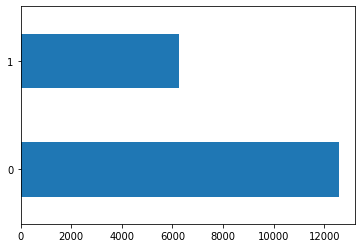

In [5]:
df = pd.read_csv("/Users/preethi/Downloads/CaseStudy/src/test_data_y_pred.csv")

pd.value_counts(df['Illness']).plot.barh(x='ABC', y='BVC')